# Dog Memorizer GAN
In this kernel we learn how to make a Dog Memorizer GAN. By publishing this kernel, it is my hope that Kaggle disallows Memorizer GANs from winning medals in this competition. Kagglers would like to invest time making complex Dog Generalizing GANs but they don't want to lose to a simple Dog Memorizing GAN. (This kernel is inspired by the tutorial [here][1] and by my previous kernels [here][2] and [here][3]).

![image](http://playagricola.com/Kaggle/gan7419.png)

A GAN consists of a Generator and Discriminator. After being trained, a Generator is a robot artist that draws dog images. During training the Discriminator teaches the Generator how to draw a dog. (And the G teaches the D also). The Generator never sees any images of dogs. Instead it continually attempts to draw a dog and is coached by the Discriminator. In this kernel, the **Memorizer** Generator is only coached to memorize images from the training set. In contrast, a **Generalizing** Generator is coached to draw images that have never existed nor been seen before!

# Load and Crop Images

[1]: https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3
[2]: https://www.kaggle.com/cdeotte/dog-autoencoder
[3]: https://www.kaggle.com/cdeotte/supervised-generative-dog-net

＃ドッグメモライザーGAN
このカーネルでは、Dog Memorizer GANの作り方を学びます。このカーネルを公開することで、KaggleがこのコンペティションでMemorizer GANがメダルを獲得することを禁止することが私の願いです。 Kagglersは複雑なDog Generalizing GANの作成に時間をかけたいと思っていますが、単純なDog Memorizing GANに負けたくはありません。 （このカーネルはチュートリアル[here] [1]と私の以前のカーネル[here] [2]と[here] [3]に触発されています）。

！[画像]（http://playagricola.com/Kaggle/gan7419.png）

GANはジェネレータとディスクリミネータで構成されています。訓練を受けたジェネレーターは犬の絵を描くロボットアーティストです。訓練中、弁別者はジェネレーターに犬の引き方を教えます。 （そしてGはDも教える）。発電機は犬の画像を見ることはありません。その代わりにそれは絶えず犬を引こうとし、弁別者によって指導されています。このカーネルでは、**Memorizer**ジェネレータはトレーニングセットからの画像を暗記するためだけにコーチされます。対照的に、**Generalizing**ジェネレータは、これまで存在したことも見たこともないような画像を描画するように指導されています。

＃画像の読み込みとトリミング

[1]：https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3
[2]：https://www.kaggle.com/cdeotte/dog-autoencoder
[3]：https://www.kaggle.com/cdeotte/supervised-generative-dog-net

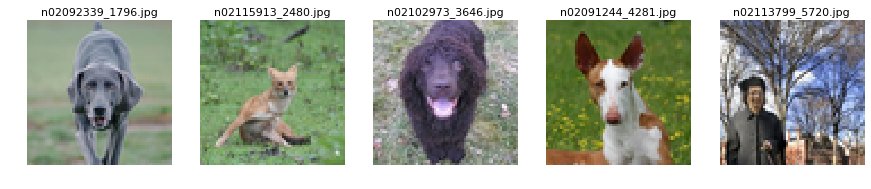

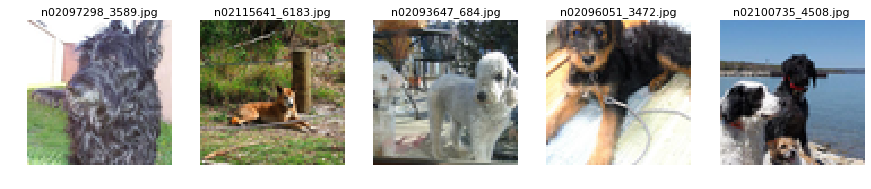

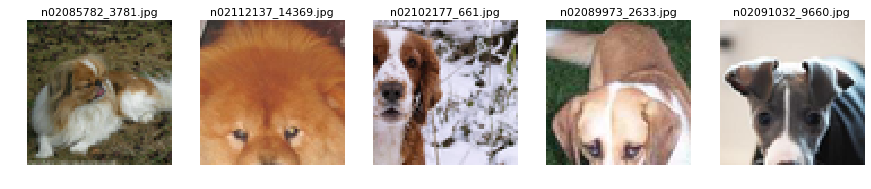

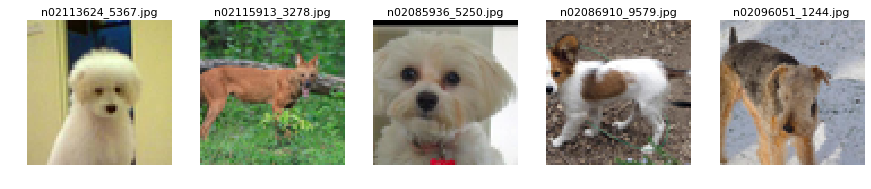

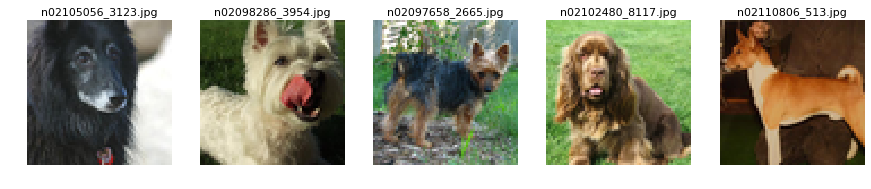

In [1]:
ComputeLB = True
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

# Build Discriminator

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [3]:
# BUILD DISCRIMINATIVE NETWORK
dog = Input((12288,))
dogName = Input((10000,))
x = Dense(12288, activation='sigmoid')(dogName) 
x = Reshape((2,12288,1))(concatenate([dog,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([dog,dogName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        122892288   input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                    
__________

# Train Discriminator
We will train the Discriminator to memorize the training images. (Typically you don't train the Discriminator ahead of time. The D learns as the G learns. But this GAN is special).

＃列車識別器
訓練画像を記憶するように識別器を訓練します。 （通常、あなたは事前に弁別器を訓練しません。Gが学ぶようにDは学びます。しかし、このGANは特別です）。

In [4]:
# TRAINING DATA
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORK
lr = 0.5
for k in range(5):
    annealer = LearningRateScheduler(lambda x: lr)
    h = discriminator.fit([zeros,train_X], train_y, epochs = 10, batch_size=256, callbacks=[annealer], verbose=0)
    print('Epoch',(k+1)*10,'/30 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /30 - loss = 0.5534208429336548
Epoch 20 /30 - loss = 0.5356205175399781
Epoch 30 /30 - loss = 0.5335282306671143
Epoch 40 /30 - loss = 0.5329873216629029
Epoch 50 /30 - loss = 0.5329110357284546


# Delete Training Images
Our Discriminator has memorized all the training images. We will now delete the training images. Our Generator will never see the training images. It will only be coached by the Discriminator. Below are examples of images that the Discriminator memorized.

＃トレーニング画像を削除する
私たちの弁護士はすべてのトレーニング画像を記憶しています。トレーニング画像を削除します。私達の発電機は訓練の画像を見ることは決してないでしょう。それは差別者によって指導されるだけです。以下は、ディスクリミネーターが記憶した画像の例です。

In [5]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


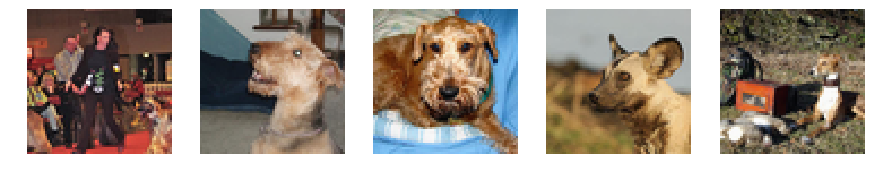

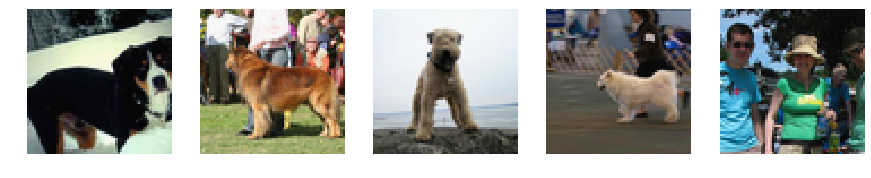

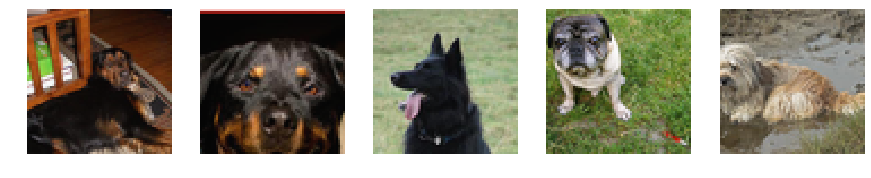

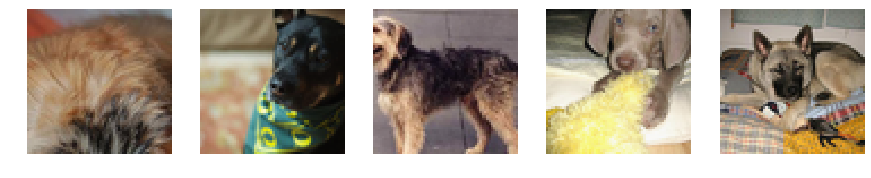

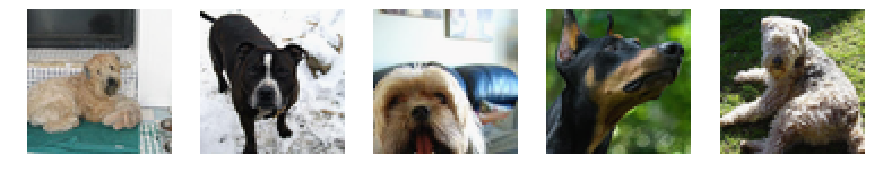

In [6]:
print('Discriminator Recalls from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Build Generator and GAN

In [7]:
# BUILD GENERATOR NETWORK
seed = Input((10000,))
generated = Dense(12288, activation='linear')(seed)

# COMPILE
generator = Model(seed, [generated,Reshape((10000,))(seed)])

# DISPLAY ARCHITECTURE
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12288)        122892288   input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 10000)        0           input_3[0][0]                    
Total params: 122,892,288
Trainable params: 122,892,288
Non-trainable params: 0
__________________________________________________________________________________________________


In [8]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
discriminator.trainable=False    
gan_input = Input(shape=(10000,))
x = generator(gan_input)
gan_output = discriminator(x)

# COMPILE GAN
gan = Model(gan_input, gan_output)
gan.get_layer('model_1').get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 122892288   input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        122892290   model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 245,784,578
Trainable params: 122,892,288
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


# Discriminator Coaches Generator
In a typical GAN, the discriminator does not memorize the training images beforehand. Instead it learns to distinquish real images from fake images at the same time that the Generator learns to make fake images. In this GAN, we taught the Discriminator ahead of time and it will now teach the Generator.

＃弁別コーチジェネレータ
典型的なＧＡＮでは、弁別器は事前にトレーニング画像を記憶しない。代わりに、ジェネレータが偽の画像を作成することを学習するのと同時に、実際の画像と偽の画像を区別することを学習します。このGANでは、私達は事前に弁別器を教えました、そしてそれは今ジェネレータに教えます。

Epoch 10 /500 - loss = 6881.3349296875


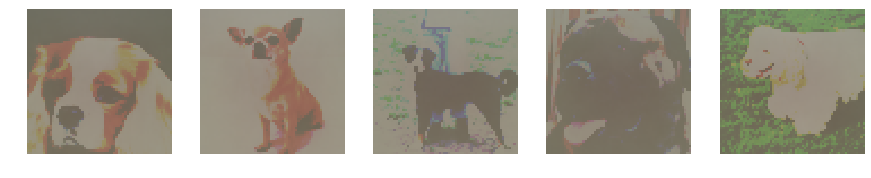

Epoch 20 /500 - loss = 2658.53484375


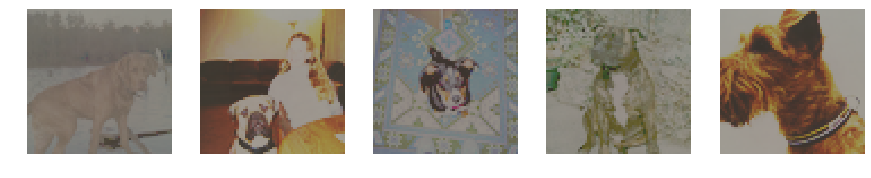

Epoch 30 /500 - loss = 1143.20518515625


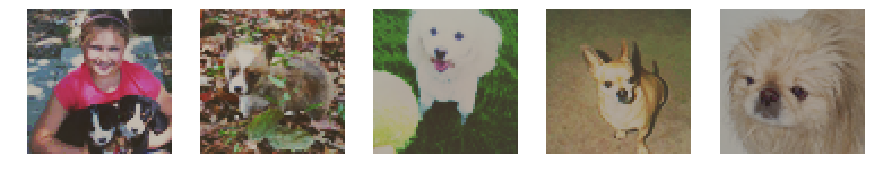

Epoch 40 /500 - loss = 477.9783235351563


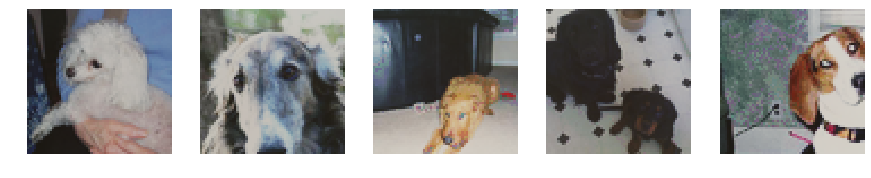

Epoch 50 /500 - loss = 198.1454177246094


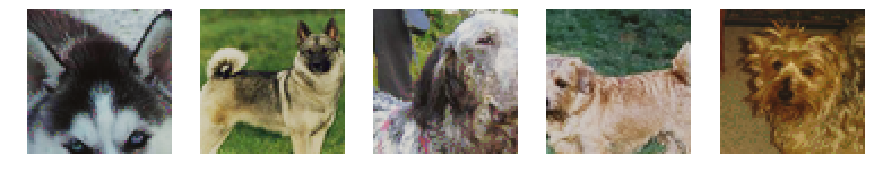

Epoch 60 /500 - loss = 86.20460021972656


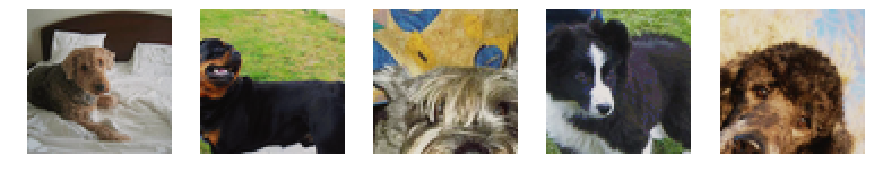

Epoch 70 /500 - loss = 43.363689086914064


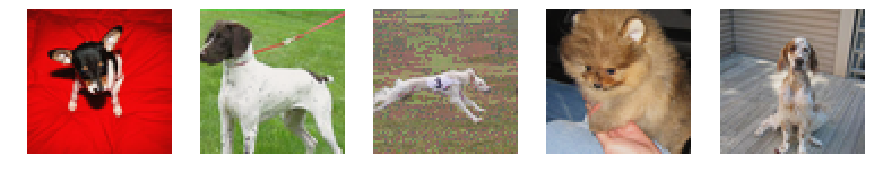

Epoch 80 /500 - loss = 28.10808857421875


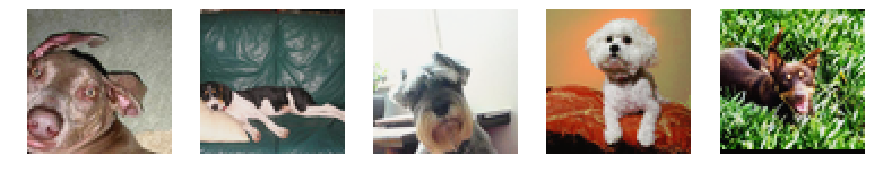

Epoch 90 /500 - loss = 23.94281138305664


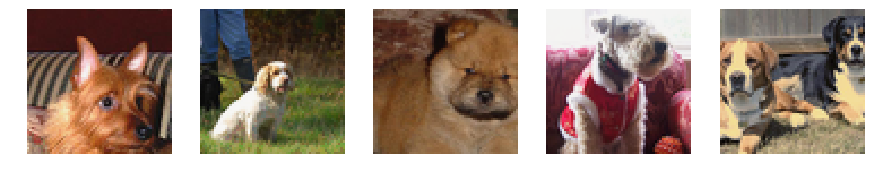

Epoch 100 /500 - loss = 16.56471340332031


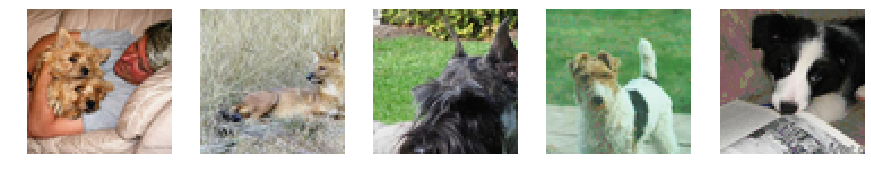

Epoch 150 /500 - loss = 2.536848014521599
Epoch 200 /500 - loss = 1.6286279710292817
Epoch 250 /500 - loss = 1.2317504715442658
Epoch 300 /500 - loss = 1.0316961089193821
Epoch 350 /500 - loss = 0.8597143156170846
Epoch 400 /500 - loss = 0.7071204993749037
Epoch 450 /500 - loss = 0.5747303797883913
Epoch 500 /500 - loss = 0.4603451762317447


In [9]:
# TRAINING DATA
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORKS
lr = 5.
for k in range(50):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR
    annealer = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = 1, batch_size=256, callbacks=[annealer], verbose=0)
    if (k<10)|(k%5==4):
        print('Epoch',(k+1)*10,'/500 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1] < 25: lr = 1.
    if h.history['loss'][-1] < 1.5: lr = 0.5
        
    # DISPLAY GENERATOR LEARNING PROGRESS
    if k<10:        
        plt.figure(figsize=(15,3))
        for j in range(5):
            xx = np.zeros((10000))
            xx[np.random.randint(10000)] = 1
            plt.subplot(1,5,j+1)
            img = generator.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
            img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show()  

# Build Generator Class
Our Generative Network has now learned all the training images from our Discriminative Network. We would like our Dog Generator to accept any random 100 dimensional vector and output an image. Furthermore we need to slightly perturb each memorized image so we don't submit exact copies of training images. Let's build a Generator Class

＃ジェネレータクラスを構築する
私たちのジェネラティブネットワークは現在、私たちの差別的ネットワークからすべてのトレーニング画像を学びました。 Dog Generatorに任意の100次元ベクトルを受け入れて画像を出力してもらいたいです。さらに、私たちはトレーニング画像の正確なコピーを提出しないように、それぞれの記憶された画像をわずかに混乱させる必要があります。ジェネレータクラスを作ろう

In [10]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((10000))
        xx[self.index] = 0.999
        xx[np.random.randint(10000)] = 0.001
        img = generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 

# Suggestion to Kaggle Judges
In my opinion, **Memorizer** GANs should be disallowed from winning prizes in Kaggle's "Generating Dog Images" competition. This kernel serves as an example of a GAN which accepts any random vector of length 100 and returns a dog image that does not exist in the training dataset. However I believe that this solution isn't what this research competition is looking for.

One can detect **Memorizer** GANs by their limited valid image output count. This GAN only outputs 10000 good images. A **Generalizing** GAN should output millions of images. Kaggle judges can verify the variety of outputted images by randomly selecting 10000 seeds (of their choice) and inputting them into a participant's GAN. Then compare those images' score to private LB score. (Each participant could provide a `DogGenerator` Class).

This kernel would pass the above test so additionally you must test for variety and generalization by choosing 2 random seeds in latent space and interpolating 100 seeds inbetween. Then convert each seed into an image. A **Generalizing** GAN should output 100 unique images that smoothly transist one to the next. And all of them should be interesting valid dog pictures. More info about latent walking [here][1]

[1]: https://www.kaggle.com/cdeotte/supervised-generative-dog-net

＃Kaggle Judgesへの提案
私の意見では、**Memorizer** GANはKaggleの "Generating Dog Images"コンペティションで優勝することはできません。このカーネルは、長さ100の任意のランダムベクトルを受け入れ、トレーニングデータセットには存在しない犬の画像を返すGANの例として機能します。しかし、私はこの解決策がこの研究コンテストが探しているものではないと信じています。

限定された有効画像出力数によってMemorizer GANを検出することができる。このGANは、10000枚の良い画像しか出力しません。 **一般化** GANは何百万もの画像を出力するはずです。 Kaggleの審査員は、ランダムに10000個のシードを選択して参加者のGANに入力することで、さまざまな出力画像を確認できます。次に、それらの画像のスコアをプライベートのLBスコアと比較します。 （各参加者は `DogGenerator`クラスを提供することができます）。

このカーネルは上記のテストに合格するので、さらに、潜在空間で2つのランダムシードを選択し、その間の100個のシードを補間することによって、多様性と一般化についてテストする必要があります。それからそれぞれの種を画像に変換します。 **一般化** GANは、あるものから次のものへ滑らかに移行する100個の固有の画像を出力するはずです。そしてそれらのすべてが面白い有効な犬の写真になるはずです。潜在的な歩行についての詳細[ここ] [1]

[1]：https://www.kaggle.com/cdeotte/supervised-generative-dog-net

# Submit to Kaggle
My hope is that Kaggle disallows **Memorizer** GANs from winning medals in this competition. The purpose of submitting this high scoring kernel is to demonstrate that it is too easy to achieve a high score with a simple **Memorizer** GAN. The more complex and interesting solutions are **Generalizing** GANs!

＃Kaggleに送信する
私の願いは、Kaggleがこのコンテストでメダルを獲得することからMemorizer GANを認めないことです。このハイスコアのカーネルを提出する目的は、単純なMemorizer GANでハイスコアを達成するのはあまりにも簡単であることを実証することです。より複雑で興味深い解決策は、GANを一般化することです。

In [11]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in range(10000):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()

# Calculate LB Score
If you wish to compute LB, you must add the LB metric dataset [here][1] to this kernel and change the boolean variable in the first cell block.

[1]: https://www.kaggle.com/wendykan/dog-face-generation-competition-kid-metric-input

＃LBスコアを計算
LBを計算したい場合は、LBメトリックデータセット[here] [1]をこのカーネルに追加し、最初のセルブロックのブール変数を変更する必要があります。

[1]：https://www.kaggle.com/wendykan/dog-face-generation-competition-kid-metric-input

In [12]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [13]:
if ComputeLB:
  
    # UNCOMPRESS OUR IMGAES
    with zipfile.ZipFile("../working/images.zip","r") as z:
        z.extractall("../tmp/images2/")

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
    
    # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
    ! rm -r ../tmp

100%|██████████| 412/412 [01:09<00:00,  4.25it/s]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (10000, 20579)
np.min(d, axis=1).shape= (10000,)
distance= 0.10344808587369207
FID_public:  7.278827315127728 distance_public:  1 multiplied_public:  7.278827315127655
